In [112]:
#imports 
from qiskit import *
from qiskit.tools.visualization import plot_bloch_multivector
from numpy import linalg as LA
import numpy as np
from qiskit.providers.aer import noise
from numpy import random

#for snapshots
from qiskit.extensions.simulator import snapshot

#for custom gates
from qiskit.transpiler.passes import Decompose
from qiskit.circuit import Gate
#from qiskit.transpiler import PassManager, transpile

%matplotlib inline

In [113]:
#initialize state vector
def normalize(vector):
    return vector / LA.norm(vector)

def initialize( vector ):
    vector = normalize(vector)
    qc.initialize(vector.tolist(),0)



In [114]:
def Encode(qc):
    sub_q = QuantumRegister(9)
    encode = QuantumCircuit(sub_q, name='encode')
    encode.cx(0,3)
    encode.cx(0,6)
    encode.h(0)
    encode.h(3)
    encode.h(6)
    encode.cx(0,1)
    encode.cx(0,2)
    encode.cx(3,4)
    encode.cx(3,5)
    encode.cx(6,7)
    encode.cx(6,8)
    encode.draw(output = 'mpl')
    sub_inst = encode.to_instruction()
    qc.append(sub_inst, [0,1,2,3,4,5,6,7,8])


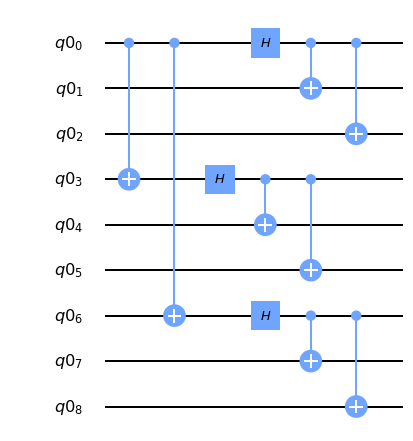

In [7]:

'------------------ draw the encoding sub - circuit -----------------------------------------'

sub_q = QuantumRegister(9)
e = QuantumCircuit(sub_q)
e.cx(0,3)
e.cx(0,6)
e.h(0)
e.h(3)
e.h(6)
e.cx(0,1)
e.cx(0,2)
e.cx(3,4)
e.cx(3,5)
e.cx(6,7)
e.cx(6,8)
e.draw(output = 'mpl')

    

In [8]:
def error(error_bitflip,error_phaseflip,qc):
    for i in range(9):
        if(random.random() < error_bitflip):
            qc.x(i)
    qc.barrier()
    for i in range(9):
        if(random.random() < error_phaseflip):
            qc.z(i)
    qc.barrier()

In [9]:
def bit_flip_correct(qc):
    correct = QuantumCircuit(5,2, name='bit_flip_correct')
    correct.initialize([1,0],3)
    correct.initialize([1,0],4)
    correct.cx(0,3)
    correct.cx(1,3)
    correct.cx(1,4)
    correct.cx(2,4)
    sub_inst = correct.to_instruction()
    
    '----------- correct bit flip in 1st block [0,1,2] using repitition code ------------------'
    
    qc.barrier()
    qc.append(sub_inst,[0,1,2,9,10])
    qc.barrier()
    syndrome = [qc.measure(9,0),qc.measure(10,1)]
    
    if(syndrome == [1,0]):
        qc.x(0)
    elif(syndrome == [0,1]):
        qc.x(2)
    elif(syndrome == [1,1]):
        qc.x(1)    
    
    '----------- correct bit flip in 2nd block [3,4,5] using repitition code -------------------'
    
    qc.barrier()
    qc.append(sub_inst,[3,4,5,9,10])
    qc.barrier()
    syndrome = [qc.measure(9,0),qc.measure(10,1)]
    
    if(syndrome == [1,0]):
        qc.x(3)
    elif(syndrome == [0,1]):
        qc.x(5)
    elif(syndrome == [1,1]):
        qc.x(4)    
    
    '----------- correct bit flip in 2nd block [3,4,5] using repitition code -------------------'
    
    
    qc.barrier()
    qc.append(sub_inst,[6,7,8,9,10])
    qc.barrier()
    syndrome = [qc.measure(9,0),qc.measure(10,1)]
    
    if(syndrome == [1,0]):
        qc.x(6)
    elif(syndrome == [0,1]):
        qc.x(8)
    elif(syndrome == [1,1]):
        qc.x(7)    
   

In [77]:
def phase_flip_correct(qc):
    correct = QuantumCircuit(11,2, name='phase_flip_correct')
    correct.initialize([1,0],9)
    correct.initialize([1,0],10)
    for i in range(9):
        correct.h(i)
    correct.barrier()
    for i in range(3):
        correct.cx(i , 10)
    correct.barrier()
    for i in range(3):
        correct.cx(i + 3 , 10)
    correct.barrier()
    for i in range(3,6):
        correct.cx(i , 9)
    correct.barrier()
    for i in range(3,6):
        correct.cx(i + 3 , 9)
    for i in range(9):
        correct.h(i)
    correct.barrier()
  
    sub_inst = correct.to_instruction()
    
    qc.barrier()
    qc.append(sub_inst,[0,1,2,3,4,5,6,7,8,9,10])
    qc.barrier()
    qc.cx(9,10)
    
    syndrome = [qc.measure(9,0),qc.measure(10,1)]
    
    if(syndrome == [1,0]):
        qc.z(6)
    elif(syndrome == [0,1]):
        qc.z(0)
    elif(syndrome == [1,1]):
        qc.z(3)    
    qc.barrier()
    print(syndrome)
    
    
        

In [107]:
def Decode(qc):
    sub_q = QuantumRegister(9)
    decode = QuantumCircuit(sub_q, name='decode')
    decode.cx(6,8)
    decode.cx(6,7)

    decode.cx(3,5)
    decode.cx(3,4)
  
    decode.cx(0,2)
    decode.cx(0,1)
   
    decode.h(0)
    decode.h(3)
    decode.h(6)
    decode.cx(0,6)
    decode.cx(0,3)
    decode.draw(output = 'mpl')   
    sub_inst = decode.to_instruction() 
    
    qc.append(sub_inst, [0,1,2,3,4,5,6,7,8])
    

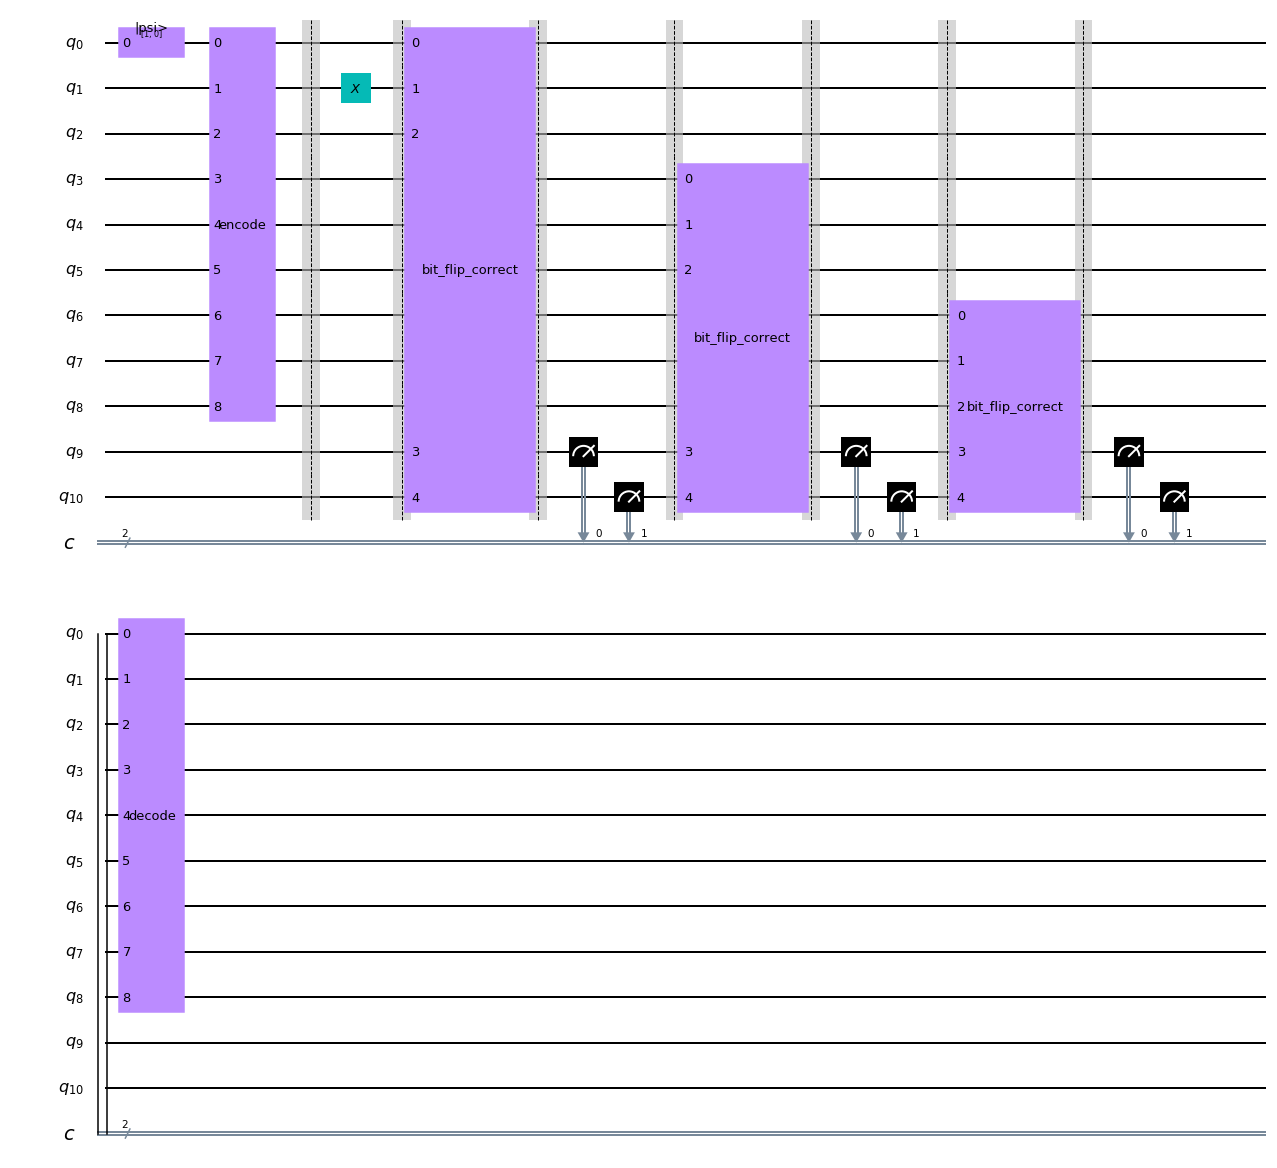

In [108]:

qc = QuantumCircuit(11,2)
initialize([1,0])
Encode(qc)
qc.barrier()
#error(0.1,0.1,qc)
qc.x(1)
#qc.z(3)
bit_flip_correct(qc)
#phase_flip_correct(qc)
Decode(qc)
qc.draw(output = 'mpl')


In [109]:
'---------------------------------- simulation -------------------------------------------------'
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc,simulator).result()
statevector = result.get_statevector()

In [110]:
print(statevector)

[0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


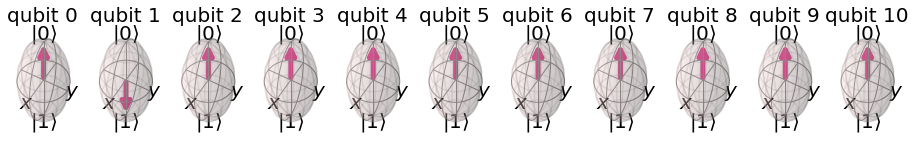

In [111]:
plot_bloch_multivector(statevector)

In [76]:
print(statevector)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


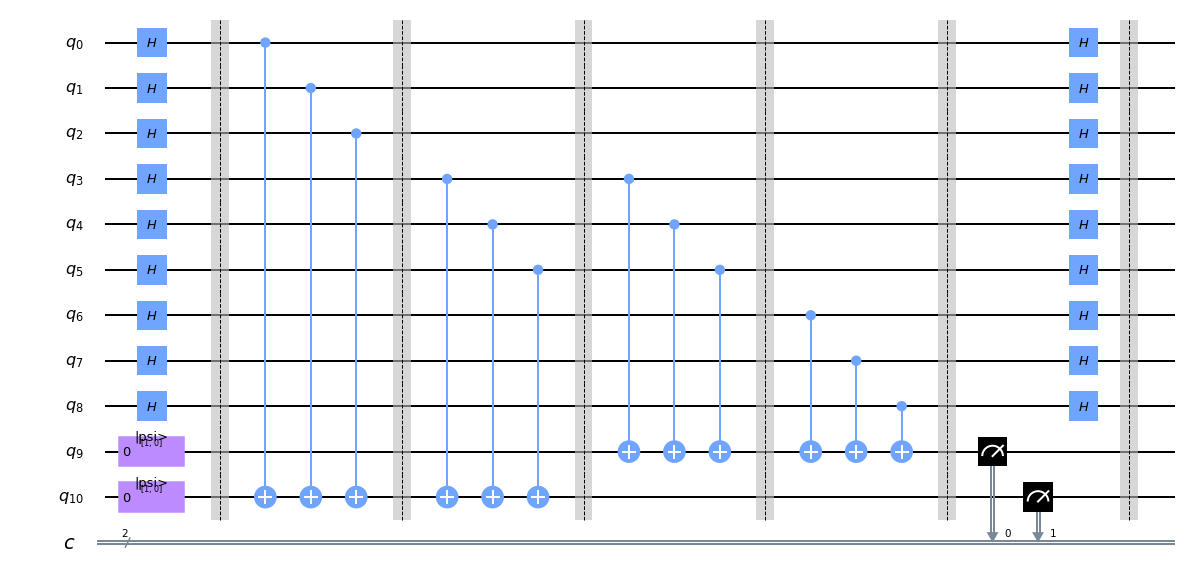

In [16]:
'----------------- sub - circuit to correct phase error -------------------------------------'
correct = QuantumCircuit(11,2, name='phase_flip_correct')
correct.initialize([1,0],9)
correct.initialize([1,0],10)
for i in range(9):
    correct.h(i)
correct.barrier()
for i in range(3):
    correct.cx(i , 10)
correct.barrier()
for i in range(3):
    correct.cx(i + 3 , 10)
correct.barrier()
for i in range(3,6):
    correct.cx(i , 9)
correct.barrier()
for i in range(3,6):
    correct.cx(i + 3 , 9)
correct.barrier()
for i in range(9):
    correct.h(i)
    
syndrome = [correct.measure(9,0),correct.measure(10,1)]
    
if(syndrome == [1,0]):
    correct.z(0)
elif(syndrome == [0,1]):
    correct.z(6)
elif(syndrome == [1,1]):
    correct.z(3)    
correct.barrier()
correct.draw(output = 'mpl')

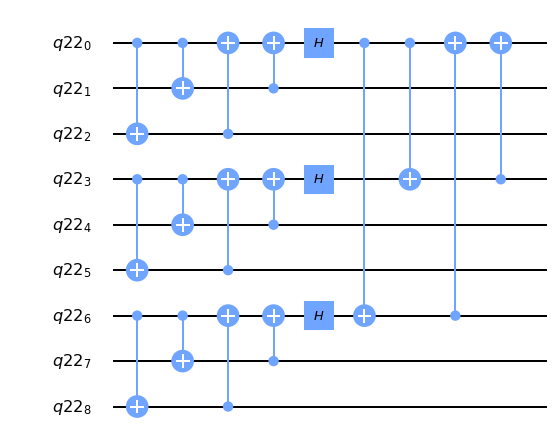

In [37]:
'----------------- sub - circuit to decode -------------------------------------'
sub_q = QuantumRegister(9)
decode = QuantumCircuit(sub_q, name='decode')
decode.cx(6,8)
decode.cx(6,7)
decode.cx(8,6)
decode.cx(7,6)
decode.cx(3,5)
decode.cx(3,4)
decode.cx(5,3)
decode.cx(4,3)
decode.cx(0,2)
decode.cx(0,1)
decode.cx(2,0)
decode.cx(1,0)
decode.h(0)
decode.h(3)
decode.h(6)
decode.cx(0,6)
decode.cx(0,3)
decode.cx(6,0)
decode.cx(3,0)
decode.draw(output = 'mpl')   

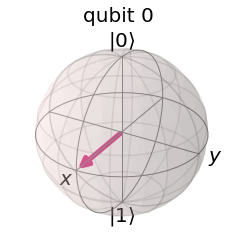

In [98]:
circuit = QuantumCircuit(1)
circuit.initialize(normalize([1,1]),0)
simulator = Aer.get_backend('statevector_simulator')
result = execute(circuit,simulator).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)